<a href="https://colab.research.google.com/github/Beerschtein/PyTorch/blob/main/HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

### Загрузим необходимые библиотеки

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import fetch_california_housing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns

### Загрузим данные и разделим их на train и test

In [2]:
housedata = fetch_california_housing()

X_train, X_test, y_train, y_test = train_test_split(housedata.data, housedata.target,
                                                    test_size = 0.25, random_state = 13)

### Посмотрим на содержимое

In [3]:
X_train, X_test, y_train, y_test

(array([[   3.5174    ,   36.        ,    4.54794521, ...,    2.06544901,
           34.21      , -118.23      ],
        [   2.9728    ,   36.        ,    4.29946524, ...,    3.2540107 ,
           34.18      , -118.37      ],
        [   1.6944    ,   11.        ,   21.37209302, ...,    1.60465116,
           40.19      , -121.08      ],
        ...,
        [   2.483     ,   20.        ,    6.27819549, ...,    2.18045113,
           37.81      , -122.29      ],
        [   6.0891    ,    5.        ,    5.46959459, ...,    3.59121622,
           32.91      , -117.16      ],
        [   2.2467    ,   46.        ,    5.94067797, ...,    3.78248588,
           37.74      , -122.18      ]]),
 array([[   4.1528    ,   15.        ,    6.19327731, ...,    3.22689076,
           35.34      , -119.08      ],
        [   3.225     ,   21.        ,    4.51486989, ...,    1.87918216,
           32.8       , -117.23      ],
        [   3.0139    ,   18.        ,    6.46875   , ...,    2.44335938,

### Стандартизируем данные

In [4]:
scale = StandardScaler()
X_train_s = scale.fit_transform(X_train)
X_test_s = scale.fit_transform(X_test)

### Для наглядности представим данные в виде таблицы

In [5]:
housedatadf = pd.DataFrame(data=X_train_s, columns = housedata.feature_names)
housedatadf['target'] = y_train
housedatadf

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,-0.181483,0.579137,-0.340021,-0.004463,-0.065383,-0.087113,-0.671762,0.675607,2.680
1,-0.468327,0.579137,-0.436304,-0.200565,-0.187060,0.012248,-0.685728,0.605994,1.902
2,-1.141668,-1.409735,6.179161,7.136066,-1.184805,-0.125634,2.112156,-0.741514,1.375
3,-0.077775,1.613350,0.300554,0.408878,-0.805871,-0.030340,1.339362,-1.666371,1.488
4,-0.495137,-0.932406,0.266794,0.063914,-0.495596,-0.054477,1.432470,-0.557537,1.413
...,...,...,...,...,...,...,...,...,...
15475,0.478689,1.852015,0.504611,-0.043365,-0.712875,-0.019584,1.004175,-1.313334,3.147
15476,0.751049,-1.330180,-0.005753,-0.181779,1.741510,0.011972,0.892446,-1.218859,2.312
15477,-0.726308,-0.693741,0.330433,0.230267,-0.992731,-0.077499,1.004175,-1.343168,1.375
15478,1.173046,-1.887064,0.017109,-0.359009,-0.320904,0.040437,-1.276962,1.207649,2.146


### Проделаем то же самое с тестовым датасетом

In [6]:
housedatadf_test = pd.DataFrame(data=X_test_s, columns = housedata.feature_names)
housedatadf_test['target'] = y_test
housedatadf_test

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,0.134522,-1.060906,0.355074,-0.270845,-0.592284,0.181330,-0.108929,0.218581,1.301
1,-0.353004,-0.585770,-0.435738,-0.051318,-0.366419,-0.734724,-1.319750,1.153256,2.294
2,-0.463929,-0.823338,0.484867,0.692060,-0.143343,-0.351246,-0.680971,1.698904,0.826
3,-1.380287,-0.031446,-0.361245,0.087657,-0.442637,-0.305399,2.784648,-1.443624,0.531
4,0.407658,-1.773609,0.136935,-0.157295,-0.405458,-0.016145,0.591822,-0.180550,1.078
...,...,...,...,...,...,...,...,...,...
5155,-0.044293,0.047744,-0.377470,0.083626,0.096464,-0.569431,-0.618999,0.142797,2.445
5156,-0.380013,0.839636,-0.035600,-0.298385,-0.417541,-0.297503,-0.066026,0.248895,0.707
5157,0.526518,-1.219284,-0.153803,-0.253921,0.058355,-0.096831,-0.595164,0.526771,3.252
5158,-1.046932,1.869097,-0.452663,-0.239688,-0.626675,0.603076,-0.695272,1.112838,0.649


In [7]:
housedatadf.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,15480.000000
mean,-1.178213e-14,3.695006e-17,-1.921954e-14,3.566025e-15,-8.560479e-17,2.363886e-17,-3.484276e-14,-5.013086e-13,2.066570
std,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.151101
min,-1.770818e+00,-2.205284e+00,-1.664270e+00,-1.542353e+00,-1.240429e+00,-2.019031e-01,-1.449211e+00,-2.367473e+00,0.149990
25%,-6.877530e-01,-8.528508e-01,-3.814381e-01,-1.820607e-01,-5.555650e-01,-5.660580e-02,-8.021129e-01,-1.109468e+00,1.198000
50%,-1.783232e-01,2.225275e-02,-7.715834e-02,-9.748002e-02,-2.274735e-01,-2.401930e-02,-6.484853e-01,5.363810e-01,1.799500
75%,4.626776e-01,6.586917e-01,2.407799e-01,5.638010e-03,2.631427e-01,1.441111e-02,9.669320e-01,7.849986e-01,2.649000
max,5.866520e+00,1.852015e+00,5.288599e+01,6.662553e+01,2.976704e+01,1.036793e+02,2.931503e+00,2.624769e+00,5.000010


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [8]:
housedatadf_test.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,5.160000e+03,5.160000e+03,5.160000e+03,5.160000e+03,5.160000e+03,5.160000e+03,5.160000e+03,5.160000e+03,5160.000000
mean,1.221762e-15,5.921189e-17,1.401463e-15,-3.118952e-15,2.323723e-17,-1.098863e-15,3.162191e-14,2.162198e-14,2.074522
std,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.162572
min,-1.784947e+00,-2.169555e+00,-2.164318e+00,-1.612905e+00,-1.303339e+00,-1.502243e+00,-1.434158e+00,-2.403561e+00,0.149990
25%,-6.882763e-01,-8.233381e-01,-4.708069e-01,-2.282050e-01,-5.894954e-01,-3.608522e-01,-7.810778e-01,-1.084911e+00,1.194000
50%,-1.683030e-01,4.774376e-02,-9.555566e-02,-1.170101e-01,-2.325736e-01,-9.938635e-02,-6.333004e-01,5.267714e-01,1.792500
75%,4.483293e-01,6.812578e-01,3.024169e-01,7.490566e-03,2.739951e-01,2.239654e-01,1.001785e+00,7.642294e-01,2.644750
max,5.834391e+00,1.869097e+00,2.139015e+01,2.492762e+01,1.367901e+01,5.452060e+01,2.999163e+00,2.547690e+00,5.000010


### Представим данные в тензорном виде

In [9]:
X_train_t = torch.from_numpy(X_train_s.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_test_t = torch.from_numpy(X_test_s.astype(np.float32))
y_test_t = torch.from_numpy(X_test.astype(np.float32))

### Разделим данные на пакеты с помощью DataLoader

In [10]:
train_data = Data.TensorDataset(X_train_t, y_train_t)
test_data = Data.TensorDataset(X_test_t, y_test_t)
train_loader = Data.DataLoader(dataset = train_data, batch_size = 128, 
                               shuffle = True, num_workers = 2)
test_loader = Data.DataLoader(dataset = test_data, batch_size = 32, 
                               shuffle = False, num_workers = 2)

### Соберем нейросеть для задачи регрессии

In [11]:
class Regression(nn.Module):
    def __init__(self):
        super(Regression, self).__init__()
        #        
        self.hidden1 = nn.Linear(in_features=8, out_features=100, bias=True)
        #        
        self.hidden2 = nn.Linear(100, 100)
        self.bn_2 = nn.BatchNorm1d(100)
        self.dp_2 = nn.Dropout(0.25)
        #
        self.hidden3 = nn.Linear(100, 50)
        self.bn_3 = nn.BatchNorm1d(50)
        self.dp_3 = nn.Dropout(0.25)
        #      
        self.predict = nn.Linear(50, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.dp_2(x)
        x = self.bn_2(x)
        x = F.relu(self.hidden3(x))
        x = self.dp_3(x)
        x = self.bn_3(x)
        output = self.predict(x)
        return output[:, 0]

In [12]:
# # Output network structure
# from torchsummary import summary
# testnet = MLPregression()
# summary(testnet, input_size=(1, 8)) # Represents 1 sample, 8 characteristics per sample

In [13]:
# !pip install torchviz

In [14]:
# # Output network structure
# from torchviz import make_dot
# testnet = MLPregression()
# x = torch.randn(1, 8).requires_grad_(True)
# y = testnet(x)
# myMLP_vis = make_dot(y, params=dict(list(testnet.named_parameters()) + [('x', x)]))
# myMLP_vis

In [15]:
testnet = Regression()

### Сначала в качестве оптимизатора используем SGD

In [16]:
optimizer = torch.optim.SGD(testnet.parameters(), lr = 0.001)
loss_func = nn.MSELoss() #            
train_loss_all = []

for epoch in range(300):
    train_loss = 0
    train_num = 0

    for step, (b_x, b_y) in enumerate(train_loader):
        output = testnet(b_x) 
        loss = loss_func(output, b_y)     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    train_loss_all.append(train_loss / train_num)

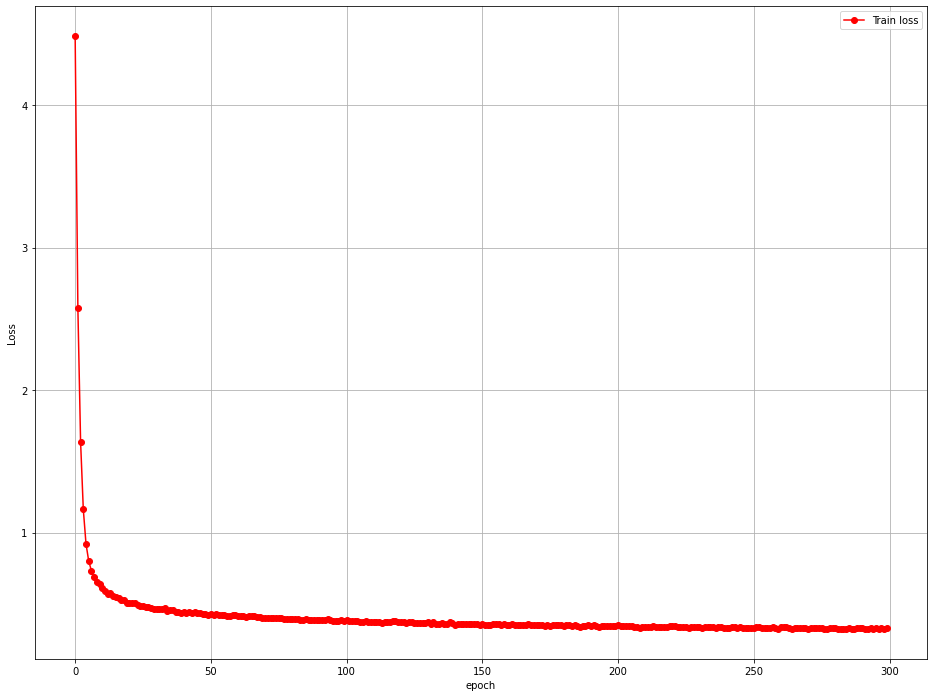

In [17]:
plt.figure(figsize = (16, 12))
plt.plot(train_loss_all, 'ro-', label = 'Train loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [18]:
y_pre = testnet(X_test_t)
y_pre = y_pre.data.numpy()
mse = mean_squared_error(y_test, y_pre)
# mae = mean_absolute_error(y_test, y_pre)
print('Среднеквадратичная ошибка равна:', mse)
# print('Средняя абсолютная ошибка равна:', mae)

Среднеквадратичная ошибка равна: 0.5456010165573534


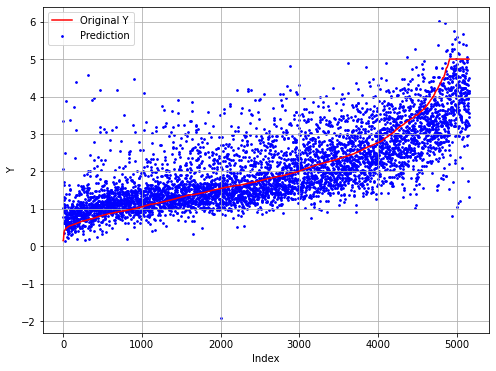

In [19]:
index = np.argsort(y_test)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_test)), y_test[index], 'r', label = 'Original Y')
plt.scatter(np.arange(len(y_pre)), y_pre[index], s = 3, c = 'b', label = 'Prediction')
plt.legend(loc = 'upper left')
plt.grid()
plt.xlabel('Index')
plt.ylabel('Y')
plt.show()

### Для сравнения в качестве оптимизатора возьмем RMSprop

In [20]:
optimizer = torch.optim.RMSprop(testnet.parameters(), lr = 0.001)
loss_func = nn.MSELoss()          
train_loss_all = []

for epoch in range(300):
    train_loss = 0
    train_num = 0

    for step, (b_x, b_y) in enumerate(train_loader):
        output = testnet(b_x)
        loss = loss_func(output, b_y)     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    train_loss_all.append(train_loss / train_num)


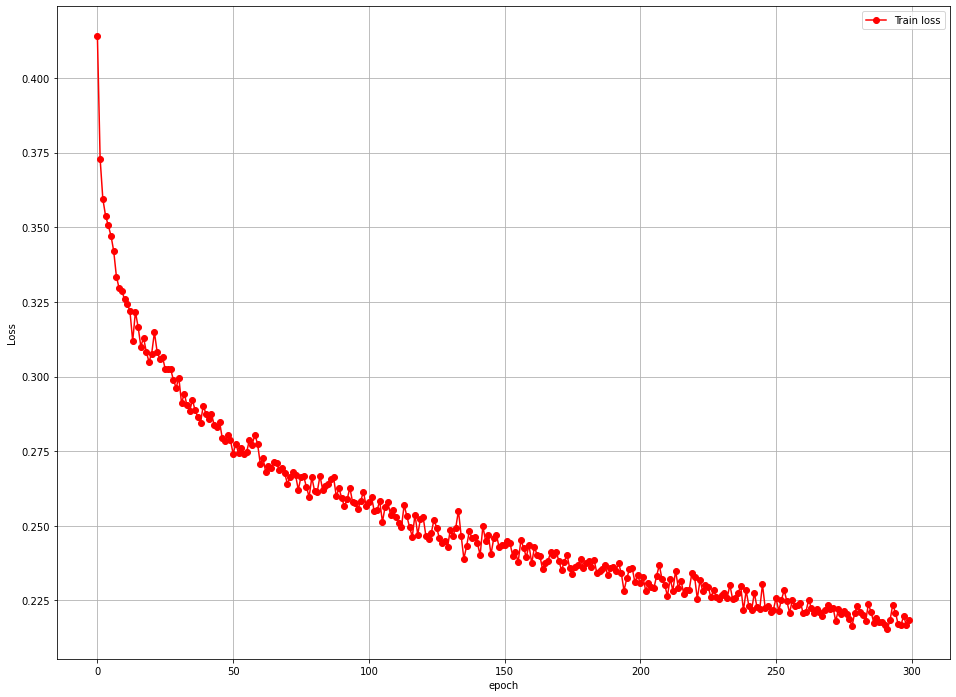

In [21]:
plt.figure(figsize = (16, 12))
plt.plot(train_loss_all, 'ro-', label = 'Train loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [22]:
y_pre = testnet(X_test_t)
y_pre = y_pre.data.numpy()
mse = mean_squared_error(y_test, y_pre)
# mae = mean_absolute_error(y_test, y_pre)
print('Среднеквадратичная ошибка равна:', mse)
# print('Средняя абсолютная ошибка равна:', mae)

Среднеквадратичная ошибка равна: 0.7933528904515423


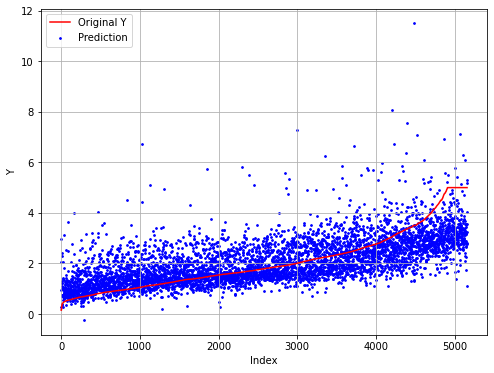

In [23]:
index = np.argsort(y_test)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_test)), y_test[index], 'r', label = 'Original Y')
plt.scatter(np.arange(len(y_pre)), y_pre[index], s = 3, c = 'b', label = 'Prediction')
plt.legend(loc = 'upper left')
plt.grid()
plt.xlabel('Index')
plt.ylabel('Y')
plt.show()

### Теперь возьмем Adam

In [24]:
optimizer = torch.optim.Adam(testnet.parameters(), lr = 0.001)
loss_func = nn.MSELoss() #            
train_loss_all = []

for epoch in range(300):
    train_loss = 0
    train_num = 0
    for step, (b_x, b_y) in enumerate(train_loader):
        output = testnet(b_x)
        loss = loss_func(output, b_y)     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    train_loss_all.append(train_loss / train_num)


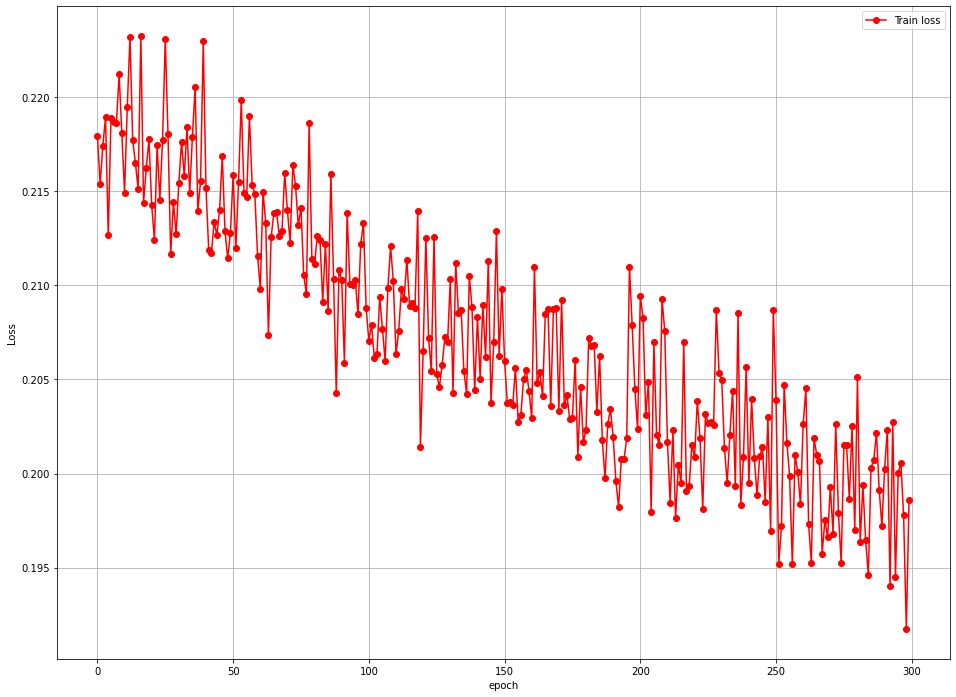

In [25]:
plt.figure(figsize = (16, 12))
plt.plot(train_loss_all, 'ro-', label = 'Train loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [26]:
y_pre = testnet(X_test_t)
y_pre = y_pre.data.numpy()
mse = mean_squared_error(y_test, y_pre)
# mae = mean_absolute_error(y_test, y_pre)
print('Среднеквадратичная ошибка равна:', mse)
# print('Средняя абсолютная ошибка равна:', mae)

Среднеквадратичная ошибка равна: 0.8101422340591539


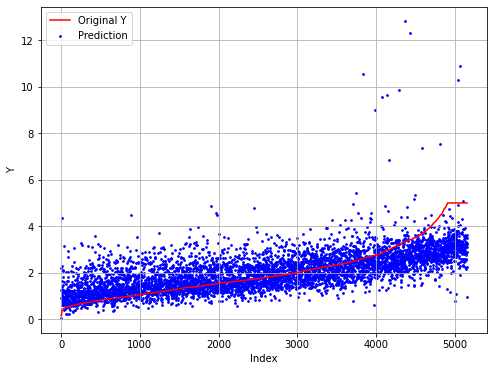

In [27]:
index = np.argsort(y_test)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_test)), y_test[index], 'r', label = 'Original Y')
plt.scatter(np.arange(len(y_pre)), y_pre[index], s = 3, c = 'b', label = 'Prediction')
plt.legend(loc = 'upper left')
plt.grid()
plt.xlabel('Index')
plt.ylabel('Y')
plt.show()

### Наилучшая сходимость алгоритма для этой сети на нашем наборе данных достигается с оптимизатором SGD. Он же показывает и наилучшую метрику на тесте, так как правильно предсказывает тенденцию изменения цены на данных, не участвовавших в обучении. Были протестированы различные варианты параметров сети (с батчнормализацией и без нее, со слоями дропаута и без них). Без батчнормализации и дропаутов сеть быстро переобучалась и их пришлось вернуть. Могу предположить, что присутствующая в RMSprop и Adam функция накопления информации о предыдущем ингредиенте позволяет оптимизаторам более эффективно двигаться в сторону глобального минимума. Но при этом наступает переобучение сети и ухудшается предсказание на тесте. SGD оказался более устойчив к переобучению и показывал стабильные и примерно одинаковые результаты при различном количестве эпох (от 30 до 300). При этом метрика MSE на обучении у него самая плохая, но в массе предсказания более точные.